In [118]:
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import time
import sys
import importlib
import os
import hashlib
import subprocess
import gc

from IPython import display
from IPython.display import clear_output
import copy
from copy import deepcopy
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

super_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{super_folder}/morphing_annealing_4d09_filtered_subset/"
folder=f"{pocket_fit_folder}/prediction_step_5/"
step_db_file=f"{pocket_fit_folder}/ddG_step_4_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step5_dG.pickle"
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step5_dG.pickle"

energy_folder="/home/energy/ykhalak/ML_dG/pde2_dG/generators/structures/set_4"
all_ligs_db_file_energy=f"{energy_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step5_dG.pickle"
all_no_core_ligs_db_file_energy=f"{energy_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step5_dG.pickle"

settings_folder=folder+"/combined_repr_search_with_repeats_and_mparam_scan/settings/"
os.makedirs(settings_folder, exist_ok=True)


Bohr2Ang=0.529177249
RT=0.001985875*300 #kcal/mol

import sys
#sys.path.insert(0, folder)
#sys.path.insert(0, f"{pocket_fit_folder}/prediction_step_0/")
sys.path.append(pocket_fit_folder)
#sys.path.append(folder)
sys.path.append(f"{pocket_fit_folder}/prediction_step_0/")

# Define representation blocks

In [2]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset

flags_2D=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.Graph_desc, dataBlocks.BCUT2D]
flags_3D=[dataBlocks.EState_FP, dataBlocks.Pharmacophore_feature_map,
          dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
          dataBlocks.AUTOCORR3D, dataBlocks.WHIM, dataBlocks.RDF,
          dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
          dataBlocks.SlogP_VSA, dataBlocks.MORSE]

no_core_flags_2D=[dataBlocks.no_core_MACCS, dataBlocks.no_core_Descriptors, dataBlocks.no_core_Graph_desc, dataBlocks.no_core_BCUT2D]
no_core_flags_3D=[dataBlocks.no_core_EState_FP, dataBlocks.no_core_Pharmacophore_feature_map,
          dataBlocks.no_core_MOE, dataBlocks.no_core_MQN,
          # dataBlocks.no_core_GETAWAY, 
          dataBlocks.no_core_AUTOCORR2D,
          dataBlocks.no_core_AUTOCORR3D, dataBlocks.no_core_WHIM, dataBlocks.no_core_RDF,
          #dataBlocks.no_core_USR, dataBlocks.no_core_USRCUT,
          dataBlocks.no_core_PEOE_VSA, dataBlocks.no_core_SMR_VSA,
          dataBlocks.no_core_SlogP_VSA, dataBlocks.no_core_MORSE]

# import training script

In [92]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset

if 'owl_trainer_w_params_general_with_ensemble_summary_model' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model
from owl_trainer_w_params_general_with_ensemble_summary_model import *

# Scan through represenatation combinations

### full ligs

In [112]:
sfiles=[]
sfiles_step=[]

normalize_x=True
shuffle_seed=12345678

n_Epochs=20000
#hl_w=300
hl_w=20
hl_depth=3
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
#weighted=False
use_dropout=True
#shiftY=False
#shiftY=True
shiftY=(1.0, -13.040057410601134)

redo=False

# nsteps=4

# sfiles=[]
# sfiles_step=[]

nrepeats=5

reprs=[]
names=["2D_3D","MDenerg","atom_hot", "2D_3D_MDenerg_atom_hot"]
best_hlws=[20,5,50,50]
best_hlds=[3,3,3,3]
# names=["2D_3D"]
# best_hlws=[20]
# best_hlds=[3]

#2D_3D
representation_flags=[0]*len(dataBlocks)
for b in flags_2D:
    representation_flags[int(b)]=1
for b in flags_3D:
    representation_flags[int(b)]=1
reprs.append(representation_flags)
#MDenerg
representation_flags=[0]*len(dataBlocks)
representation_flags[int(dataBlocks.MDenerg)]=1
reprs.append(representation_flags)
#atom_hot
representation_flags=[0]*len(dataBlocks)
representation_flags[int(dataBlocks.atom_hot)]=1
reprs.append(representation_flags)
# 2D_3D + MDenerg + atom_hot
representation_flags=[0]*len(dataBlocks)
for b in flags_2D:
    representation_flags[int(b)]=1
for b in flags_3D:
    representation_flags[int(b)]=1
representation_flags[int(dataBlocks.MDenerg)]=1
representation_flags[int(dataBlocks.atom_hot)]=1
reprs.append(representation_flags)

for ri,representation_flags in enumerate(reprs):
    hl_w=best_hlws[ri]
    hl_depth=best_hlds[ri]
    
    for step in [5]:
        cur_settings_folder=f"{pocket_fit_folder}/prediction_step_{step}/training_w_better_shiftY_v3/settings/"
        os.makedirs(cur_settings_folder, exist_ok=True)


        for rep in range(nrepeats):
            dr_name=f"{names[ri]}_repeat{rep}"

            settings=[
                representation_flags, dr_name, normalize_x, shuffle_seed,
                n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
                impfilt, X_filter,
                weighted, shiftY, use_dropout
                ]

            sha = hashlib.sha256()
            sha.update(pickle.dumps(settings))
            settings_hash=dr_name+"_"+sha.hexdigest()[:10]

            settings_fname=cur_settings_folder+f"{settings_hash}.pickle"
            if(os.path.exists(settings_fname)):
                with open(settings_fname, 'rb') as f:
                    settings_loaded, metrics = pickle.load(f)
                    if(metrics is not None and not redo):
                        print(f"{settings_fname} is already trained.")
                    else:
                        print(f"{settings_fname} exists but is not trained yet.")
    #                     sfiles.append(settings_fname)
    #                     sfiles_step.append(step)
            else:
                pickle.dump( (settings, None), open( settings_fname, "wb" ) )
    #             sfiles.append(settings_fname)
    #             sfiles_step.append(step)

            sfiles.append(settings_fname)
            sfiles_step.append(step)

/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_repeat0_c800ae33e5.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_repeat1_6ec6f02dc8.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_repeat2_1630c68309.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_repeat3_811981a25d.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY

# Copy data for the needed ligands

In [106]:
step=5
#validation_indeces=[1, 2, 3, 4, 13, 24, 27, 33, 45, 48, 53, 56, 58, 63, 70, 71, 87, 89, 91, 214, 265, 346, 365, 418, 419, 420, 425, 427, 598, 1175, 1230, 1480, 1481, 1741, 1762, 1803, 2148, 2150, 2152, 2292, 2354, 2362, 2416, 2423, 2484, 2498, 3429, 3567, 3569, 3623, 3702, 4028, 5251, 8898, 15508]
known_ligs_databse_fn=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle"
with open(known_ligs_databse_fn, 'rb') as f:
    set4f_ligs = pickle.load(f)
    known_ligs = [l for l in set4f_ligs if l.HasProp('dG')]
lig_names = [l.GetProp('ID') for l in known_ligs if l.HasProp('dG')]
lig_names.append(set4f_ligs[0].GetProp('ID'))
known_ligs.append(set4f_ligs[0])
del set4f_ligs
_=gc.collect()

validation_db_file=f"{pocket_fit_folder}/expt_validation_ligands.pickle"
with open(validation_db_file, 'rb') as f:
    val_ligs = pickle.load(f)
val_names = [l.GetProp('ID') for l in val_ligs]
# del val_ligs
# _=gc.collect()

lig_names+=val_names
known_ligs+=val_ligs

In [97]:
# print(val_names)
# print([l.GetProp('dG') for l in val_ligs])

In [108]:
source_f=f"{pocket_fit_folder}/prediction_step_0/combined_modular_repr_cache"
destin_f=f"{pocket_fit_folder}/prediction_step_{step}/cached_reprs/combined_modular_repr_cache"

for representation_flags in tqdm(reprs):
    repr_hash=hashlib.md5(np.packbits(np.array(representation_flags, dtype=bool)).tobytes()).hexdigest()
#     print(repr_hash)
    
    src=f"{source_f}/{repr_hash}"
    dst=f"{destin_f}/{repr_hash}"
    os.makedirs(dst, exist_ok=True)
    
    #for ID in lig_names:
        #shutil.copy(f"{src}/{ID}.pickle", f"{dst}/{ID}.pickle")
    for lig in known_ligs:
        ID=lig.GetProp('ID')
        with open(f"{src}/{ID}.pickle", 'rb') as f:
            X,Y = pickle.load(f)
            Y = np.array([float(lig.GetProp('dG')) if lig.HasProp('dG') else np.nan]) # kcal/mol
        with open(f"{dst}/{ID}.pickle", 'wb') as f:
            pickle.dump((X, Y), f)
    
    shutil.copy(f"{src}/normalization_factors__no_X_filter.dat", f"{dst}/normalization_factors__no_X_filter.dat")

100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


# Run locally

In [113]:
for i,f in tqdm(enumerate(sfiles)):
    settings_fname=f
    step=sfiles_step[i]
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is not None):
            continue;
    if("atom_hot" not in settings_loaded[1]):
        continue

    print("######################################")
    print(settings_fname)
    print(settings_loaded[1])
    print("######################################")
#     raise()

    train_model_with_settings_general_ensemble(
              settings_fname, False,
              #torch.device("cpu"),
              torch.device("cuda:0"),
              True,
              datafolder=f"{pocket_fit_folder}/prediction_step_5/cached_reprs/",
              #datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_3/combined_repr_search",
              save_folder_base=f"{pocket_fit_folder}/prediction_step_{step}/training_w_better_shiftY_v3",
              all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle",
              all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step{step}_dG.pickle",
              validation_db_file=f"{pocket_fit_folder}/expt_validation_ligands.pickle",
              no_core_validation_db_file=f"{pocket_fit_folder}/expt_validation_ligands_no_core.pickle",
              train_summary_model=True,
              predict_all_ligs=False
             )
    raise()

print("Done.")

10it [00:00, 46.32it/s]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/atom_hot_repeat0_dc5de9d8f1.pickle
atom_hot_repeat0
######################################




Representation: atom_hot_repeat0
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 18:53:54.781516
Read ligands 2022-03-02 18:53:57.762737
# of training ligands found: 595 2022-03-02 18:53:57.790666
# starting ligands: 595 2022-03-02 18:53:57.997079
Finished setting up weights 2022-03-02 18:53:57.998663
Building the internal_filtered_cache needs 2771.6063385009766 MB, more than the 0.0 MB limit. SKIPPING and will read samples from HDD each time instead.
Found normalization factors across all ligands 2022-03-02 18:54:05.246011
There are 55 validation ligands


10it [00:14, 46.32it/s]

	Epoch: 9	 train_loss=1.2061+-0.1425	 XVal_RMSE=2.3367	 Val_RMSE=1.6689+-0.1231	 sm_train_loss=1.556	 sm_Val_RMSE=1.7111
	Epoch: 19	 train_loss=0.7689+-0.0491	 XVal_RMSE=2.1792	 Val_RMSE=1.5648+-0.1476	 sm_train_loss=1.384	 sm_Val_RMSE=1.5518
	Epoch: 29	 train_loss=0.5609+-0.0731	 XVal_RMSE=2.1701	 Val_RMSE=1.4729+-0.1726	 sm_train_loss=1.263	 sm_Val_RMSE=1.4374
	Epoch: 39	 train_loss=0.4343+-0.0574	 XVal_RMSE=2.1299	 Val_RMSE=1.3905+-0.1701	 sm_train_loss=1.138	 sm_Val_RMSE=1.3222
	Epoch: 49	 train_loss=0.3660+-0.0770	 XVal_RMSE=2.1359	 Val_RMSE=1.3215+-0.1630	 sm_train_loss=1.078	 sm_Val_RMSE=1.2710


10it [00:24,  2.40s/it]


KeyboardInterrupt: 

In [110]:
with open("/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_5/cached_reprs/combined_modular_repr_cache/793f8fc2ef51d558a6cd17022f751801/set4_0.pickle", 'rb') as f:
    temp_lig_repr = pickle.load(f)
print(temp_lig_repr)

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([nan]))


# Copy step 5 databases to energy

In [5]:
import shutil
step=5

all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle"
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step{step}_dG.pickle"

energy_folder_on_workstation="/netmount/energy/ykhalak/ML_dG/pde2_dG/generators/structures/set_4"
all_ligs_db_file_energy=f"{energy_folder_on_workstation}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle"
all_no_core_ligs_db_file_energy=f"{energy_folder_on_workstation}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step{step}_dG.pickle"

shutil.copy(all_ligs_db_file, all_ligs_db_file_energy)
shutil.copy(all_no_core_ligs_db_file, all_no_core_ligs_db_file_energy)

'/netmount/energy/ykhalak/ML_dG/pde2_dG/generators/structures/set_4/filtered_subset_without_weird_chemistry_no_core_ligs_with_step5_dG.pickle'

# Run on moa

In [114]:
import queue
import threading

previously_done=0
max_debug_evals=10e8

fits_per_job=1

cmd_str=f"source /etc/profile; module load sge;"
cmd_str_SLURM=f"source /etc/profile;"

fits_written_to_jobs=0
fits_not_trained=0

for step in [5]:
    job_id=0
    fits_this_job=0
    fit_commands_this_job=""
    
    cwd=f"{pocket_fit_folder}/prediction_step_{step}/training_w_better_shiftY_v3/local_runs/"
    os.makedirs(cwd, exist_ok=True)

    save_folder_base=f"{pocket_fit_folder}/prediction_step_{step}/training_w_better_shiftY_v3"
    all_ligs_db_file_energy=f"{energy_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle"
    all_no_core_ligs_db_file_energy=f"{energy_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step{step}_dG.pickle"
    validation_db_file=f"{pocket_fit_folder}/expt_validation_ligands.pickle"
    no_core_validation_db_file=f"{pocket_fit_folder}/expt_validation_ligands_no_core.pickle"
    
    for i,f in enumerate(tqdm(sfiles)):
        settings_fname=f
    #     step=sfiles_step[i]
        if(not os.path.exists(settings_fname)):
            continue;
        with open(settings_fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is None and step==sfiles_step[i]):
                fits_not_trained+=1
                fits_this_job+=1
                fit_commands_this_job+=f"""
python /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/owl_trainer_w_params_general_with_ensemble_summary_model.py\
 -v -f {settings_fname} --datafolder $TMPDIR --save_folder_base {save_folder_base}\
 --ligsf {all_ligs_db_file_energy} --nocoref {all_no_core_ligs_db_file_energy}\
 --valsf {validation_db_file} --nocorevalsf {no_core_validation_db_file}\
 --no_pred --sm

 """

        if(fits_this_job>=fits_per_job or (i>=len(sfiles)-1 and fits_this_job>0)):

            jobscript_str=f"""#!/bin/bash

#$ -S /bin/bash
#$ -pe openmp_fast 10
#$ -q *
#$ -N pytorch_GPU_worker_{job_id}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=5:00:00
#$ -wd {cwd}

#SBATCH --job-name=pytorch_SLURM_GPU_worker_{job_id}
#SBATCH --get-user-env
#SBATCH --gres=gpu:1              # number of GPUs requested
#SBATCH --ntasks=1                # Number of MPI process
#SBATCH --cpus-per-task=10        # CPU cores per MPI process
##SBATCH -p p24,p20,p16,p10,p08,p06    # partitions to use
#SBATCH -p p10,p08,p06            # partitions to use
#SBATCH -t 5:00:0                 # hours:min:sec
#SBATCH --chdir={cwd}
#SBATCH -e repr_scan_{job_id}-%j.err
#SBATCH -o repr_scan_{job_id}-%j.out

if [ -n "$NHOSTS" ]; then
    echo "Env. variable NHOSTS found, assuming we are using SGE."
    module load shared                           # access to modules in /cm/shared
else
    echo "Env. variable NHOSTS not set, assuming we are using SLURM."
    export NHOSTS=$SLURM_JOB_NUM_NODES
    export NSLOTS=$SLURM_CPUS_PER_TASK
fi

echo NHOSTS=$NHOSTS
echo NSLOTS=$NSLOTS
echo TMPDIR=$TMPDIR
hostname

echo "#################################################"

export OMP_NUM_THREADS=$NSLOTS
export MKL_NUM_THREADS=$NSLOTS

source ~/.ML_v2_profile
#source ~/.ML_v2_on_energy_profile

cp /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_5/cached_reprs/deployable_training_data_with_validation_ligs.tar.gz $TMPDIR/.
cd $TMPDIR
tar -zxf deployable_training_data_with_validation_ligs.tar.gz
cd {cwd}

echo "Done extracting data"

{fit_commands_this_job}
"""

            jobscript_fn=cwd+"/jobscript_{}".format(job_id)
            with open(jobscript_fn,"w") as f:
                f.write(jobscript_str)

            cmd_str+=f" cd {cwd}; qsub {jobscript_fn};"
            cmd_str_SLURM+=f" sbatch {jobscript_fn};"

            job_id+=1
            
            fits_written_to_jobs+=fits_this_job
            fit_commands_this_job=""
            fits_this_job=0
            
            

    print(len(sfiles), fits_not_trained, fits_written_to_jobs)
#     print(fits_this_job, i)
#     raise()

print("Submitting.")
# ssh_cmd_arr=["ssh", "owl", cmd_str]
ssh_cmd_arr=["ssh", "moa2", cmd_str_SLURM]
process = subprocess.Popen(ssh_cmd_arr, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
outs, _ = process.communicate()
process.wait()
print('== subprocess exited with rc =', process.returncode)
print(outs.decode('utf-8'))
print("Done.")

100%|██████████| 20/20 [00:00<00:00, 97.55it/s]


20 10 10
Submitting.
== subprocess exited with rc = 0
Submitted batch job 546053
Submitted batch job 546054
Submitted batch job 546055
Submitted batch job 546056
Submitted batch job 546057
Submitted batch job 546058
Submitted batch job 546059
Submitted batch job 546060
Submitted batch job 546061
Submitted batch job 546062

Done.


# Predict dG locally

In [115]:
for i,f in enumerate(tqdm(sfiles)):
    settings_fname=f
    step=sfiles_step[i]
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            continue;
        elif(metrics.summary_model_best_pred is not None):
            continue;

    print("######################################")
    print(settings_fname, "step", step)
    print("######################################")
#     raise()

    Predict_from_saved_models_ensemble(settings_fname, redo=True,
                                      #torch.device("cpu"),
                                      device=torch.device("cuda:0"),
                                      show_progress=True,
                                      #datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_3/combined_repr_search",
                                      datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0",
                                      save_folder_base=f"{pocket_fit_folder}/prediction_step_{step}/training_w_better_shiftY_v3",
                                      all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step{step}_dG.pickle",
                                      all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step{step}_dG.pickle",
                                      max_cache_Mem_MB=1024*6,
                                     )
#     raise()

print("Done.")

  0%|          | 0/20 [00:00<?, ?it/s]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_repeat0_c800ae33e5.pickle step 5
######################################
Representation: 2D_3D_repeat0
NN width: 20
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:40:22.240647
Found normalization factors across all ligands 2022-03-02 20:41:25.535776
Loaded models 2022-03-02 20:41:26.023482
summary_models were found.
Finished predictions 2022-03-02 20:41:32.816612


  5%|▌         | 1/20 [01:12<22:52, 72.22s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_repeat1_6ec6f02dc8.pickle step 5
######################################
Representation: 2D_3D_repeat1
NN width: 20
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:41:34.500726
Found normalization factors across all ligands 2022-03-02 20:41:39.658344
Loaded models 2022-03-02 20:41:40.137711
summary_models were found.
Finished predictions 2022-03-02 20:41:46.885866


 10%|█         | 2/20 [01:26<11:24, 38.03s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_repeat2_1630c68309.pickle step 5
######################################
Representation: 2D_3D_repeat2
NN width: 20
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:41:48.610278
Found normalization factors across all ligands 2022-03-02 20:41:53.792458
Loaded models 2022-03-02 20:41:54.214564
summary_models were found.
Finished predictions 2022-03-02 20:42:01.145460


 15%|█▌        | 3/20 [01:40<07:42, 27.20s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_repeat3_811981a25d.pickle step 5
######################################
Representation: 2D_3D_repeat3
NN width: 20
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:42:02.910553
Found normalization factors across all ligands 2022-03-02 20:42:18.149255
Loaded models 2022-03-02 20:42:19.138264
summary_models were found.
Finished predictions 2022-03-02 20:42:26.267344


 20%|██        | 4/20 [02:05<07:03, 26.44s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_repeat4_5ee371ac9c.pickle step 5
######################################
Representation: 2D_3D_repeat4
NN width: 20
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:42:28.377452
Found normalization factors across all ligands 2022-03-02 20:42:34.073441
Loaded models 2022-03-02 20:42:34.461711
summary_models were found.
Finished predictions 2022-03-02 20:42:41.364101


 25%|██▌       | 5/20 [02:20<05:33, 22.26s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/MDenerg_repeat0_386e73be28.pickle step 5
######################################
Representation: MDenerg_repeat0
NN width: 5
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:42:43.112349
Found normalization factors across all ligands 2022-03-02 20:43:08.320533
Loaded models 2022-03-02 20:43:08.702802
summary_models were found.
Finished predictions 2022-03-02 20:43:13.657540


 30%|███       | 6/20 [02:53<05:59, 25.68s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/MDenerg_repeat1_c10bde236b.pickle step 5
######################################
Representation: MDenerg_repeat1
NN width: 5
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:43:15.466532
Found normalization factors across all ligands 2022-03-02 20:43:19.716610
Loaded models 2022-03-02 20:43:20.289847
summary_models were found.
Finished predictions 2022-03-02 20:43:25.271183


 35%|███▌      | 7/20 [03:04<04:34, 21.08s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/MDenerg_repeat2_067775dac0.pickle step 5
######################################
Representation: MDenerg_repeat2
NN width: 5
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:43:27.017039
Found normalization factors across all ligands 2022-03-02 20:43:31.292372
Loaded models 2022-03-02 20:43:31.676023
summary_models were found.
Finished predictions 2022-03-02 20:43:36.641708


 40%|████      | 8/20 [03:16<03:35, 17.97s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/MDenerg_repeat3_f972a34172.pickle step 5
######################################
Representation: MDenerg_repeat3
NN width: 5
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:43:38.333705
Found normalization factors across all ligands 2022-03-02 20:43:42.789255
Loaded models 2022-03-02 20:43:43.226860
summary_models were found.
Finished predictions 2022-03-02 20:43:48.222389


 45%|████▌     | 9/20 [03:27<02:55, 15.98s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/MDenerg_repeat4_46b96fa80e.pickle step 5
######################################
Representation: MDenerg_repeat4
NN width: 5
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:43:49.984583
Found normalization factors across all ligands 2022-03-02 20:43:54.288744
Loaded models 2022-03-02 20:43:54.858649
summary_models were found.
Finished predictions 2022-03-02 20:43:59.876725


 50%|█████     | 10/20 [03:39<02:26, 14.65s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/atom_hot_repeat0_dc5de9d8f1.pickle step 5
######################################
Representation: atom_hot_repeat0
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:44:01.619936
Found normalization factors across all ligands 2022-03-02 20:46:18.983052
Loaded models 2022-03-02 20:46:21.176504
summary_models were found.
Finished predictions 2022-03-02 20:46:33.765156


 55%|█████▌    | 11/20 [06:15<08:41, 57.91s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/atom_hot_repeat1_4270880283.pickle step 5
######################################
Representation: atom_hot_repeat1
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:46:37.651412
Found normalization factors across all ligands 2022-03-02 20:48:54.226913
Loaded models 2022-03-02 20:48:56.618197
summary_models were found.
Finished predictions 2022-03-02 20:49:09.722041


 60%|██████    | 12/20 [08:50<11:39, 87.49s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/atom_hot_repeat2_fb04c340b0.pickle step 5
######################################
Representation: atom_hot_repeat2
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:49:12.826529
Found normalization factors across all ligands 2022-03-02 20:51:32.650384
Loaded models 2022-03-02 20:51:35.513130
summary_models were found.
Finished predictions 2022-03-02 20:51:48.417434


 65%|██████▌   | 13/20 [11:28<12:43, 109.00s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/atom_hot_repeat3_7b3c689096.pickle step 5
######################################
Representation: atom_hot_repeat3
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:51:51.317771
Found normalization factors across all ligands 2022-03-02 20:54:06.465609
Loaded models 2022-03-02 20:54:09.197140
summary_models were found.
Finished predictions 2022-03-02 20:54:22.272271


 70%|███████   | 14/20 [14:03<12:15, 122.62s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/atom_hot_repeat4_a6df7f519e.pickle step 5
######################################
Representation: atom_hot_repeat4
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:54:25.384588
Found normalization factors across all ligands 2022-03-02 20:56:42.548372
Loaded models 2022-03-02 20:56:45.196506
summary_models were found.
Finished predictions 2022-03-02 20:56:58.274029


 75%|███████▌  | 15/20 [16:38<11:03, 132.63s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_MDenerg_atom_hot_repeat0_fa77f76707.pickle step 5
######################################
Representation: 2D_3D_MDenerg_atom_hot_repeat0
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:57:01.267967
Found normalization factors across all ligands 2022-03-02 20:58:01.122234
Loaded models 2022-03-02 20:58:06.701443
summary_models were found.
Finished predictions 2022-03-02 20:58:23.973284


 80%|████████  | 16/20 [18:05<07:54, 118.67s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_MDenerg_atom_hot_repeat1_4f8b22c53e.pickle step 5
######################################
Representation: 2D_3D_MDenerg_atom_hot_repeat1
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 20:58:27.431098
Found normalization factors across all ligands 2022-03-02 21:00:24.886698
Loaded models 2022-03-02 21:00:29.470974
summary_models were found.
Finished predictions 2022-03-02 21:00:46.495303


 85%|████████▌ | 17/20 [20:27<06:17, 125.85s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_MDenerg_atom_hot_repeat2_c5338fbeb0.pickle step 5
######################################
Representation: 2D_3D_MDenerg_atom_hot_repeat2
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 21:00:49.974550
Found normalization factors across all ligands 2022-03-02 21:02:56.817696
Loaded models 2022-03-02 21:03:01.305642
summary_models were found.
Finished predictions 2022-03-02 21:03:18.849887


 90%|█████████ | 18/20 [22:59<04:27, 133.80s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_MDenerg_atom_hot_repeat3_c5f6bfe8e4.pickle step 5
######################################
Representation: 2D_3D_MDenerg_atom_hot_repeat3
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 21:03:22.289366
Found normalization factors across all ligands 2022-03-02 21:05:21.906419
Loaded models 2022-03-02 21:05:26.584525
summary_models were found.
Finished predictions 2022-03-02 21:05:44.498645


 95%|█████████▌| 19/20 [25:25<02:17, 137.37s/it]

######################################
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_5/training_w_better_shiftY_v3/settings/2D_3D_MDenerg_atom_hot_repeat4_d4ee184577.pickle step 5
######################################
Representation: 2D_3D_MDenerg_atom_hot_repeat4
NN width: 50
NN depth: 3
Normalization of features: True
Feature filtering: None
Loss weighted by dG frequency: True
Prediction dG shifted and rescaled: (1.0, -13.040057410601134)
2022-03-02 21:05:47.957020
Found normalization factors across all ligands 2022-03-02 21:07:16.013718
Loaded models 2022-03-02 21:07:17.940000
summary_models were found.
Finished predictions 2022-03-02 21:07:32.373578


100%|██████████| 20/20 [27:12<00:00, 81.60s/it] 

Done.


# What are the best binders according to 2D_3D?

## load predictions

In [116]:
step=5
cur_settings_folder=f"{pocket_fit_folder}/prediction_step_{step}/training_w_better_shiftY_v3/settings/"

wanted_repr="2D_3D"

P=[]
sfiles = next(os.walk(cur_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
for fn in sfiles:
    settings_fname=cur_settings_folder+"/"+fn
    metrics=None
    with open(settings_fname, 'rb') as f:
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception as e:
            print(f"problem with {fn}")
            raise(e)

    if(metrics is not None):
        key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}_hld{settings_loaded[6]}"
        if(wanted_repr+"_repeat" in key):
            P.append(metrics.best_pred[0])
            
P=np.mean(np.array(P), axis=0)

## exclude validation IDs from unmeasured ligands

In [117]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

core_smiles="c7(C)nc8ccccc8n8c(c6c(Cl)[cH][cH][cH][cH]6)nnc78"
core=Chem.MolFromSmiles(core_smiles)

# find validation and non-validation ligands
training_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG//aligned_w_pmx_library_new_structures_similar2xrays.pickle"
with open(training_databse_fn, 'rb') as f:
    expt_ligs = pickle.load(f)
expt_ligs=[l for l in expt_ligs if not("<" in l.GetProp("[Q] hPDE2_pIC50") or ">" in l.GetProp("[Q] hPDE2_pIC50"))]

with suppress_stdout_stderr():
    res,unmatched = rdRGD.RGroupDecompose([core], expt_ligs, asSmiles=True)# print(unmatched)
matched_expt_ligs=[expt_ligs[i] for i in range(len(expt_ligs)) if not i in unmatched]

#filter out H's as R-groups
validation_ligs=[]
for i,l in enumerate(tqdm(res)):
    new_l={}
    for rg in l:
        if rg=='Core':
            continue;
        if l[rg][:3]!='[H]':
            new_l[rg]=l[rg]
    if(len(new_l)==1):
        validation_ligs.append(matched_expt_ligs[i])
print(f"found {len(validation_ligs)} validation ligands")

del expt_ligs, matched_expt_ligs
_=gc.collect()

100%|██████████| 136/136 [00:00<00:00, 400861.10it/s]

found 69 validation ligands


In [119]:
from rdkit.Chem import rdmolops
validation_smiles=[Chem.MolToSmiles(rdmolops.RemoveHs(lig)) for lig in validation_ligs]

validation_ids_in_set4f=[]
validation_ids_in_validation_subset=[]
unmeasured_ids_in_set4f=[]
measured_ids_in_set4f=[]

#load only if not curretly loaded
try:
    ligs_set4f
except NameError:
    with open(all_ligs_db_file, 'rb') as f:
        ligs_set4f = pickle.load(f)

for i,lig in enumerate(tqdm(ligs_set4f)):
    smi=Chem.MolToSmiles(rdmolops.RemoveHs(lig))
    if(smi in validation_smiles):
        validation_ids_in_set4f.append(i)
        j=validation_smiles.index(smi)
        validation_ids_in_validation_subset.append(j)
    elif(not lig.HasProp('dG')):
        unmeasured_ids_in_set4f.append(i)
    else:
        measured_ids_in_set4f.append(i)
        
unmeasured_ids_in_set4f=np.array(unmeasured_ids_in_set4f)

100%|██████████| 34114/34114 [00:09<00:00, 3722.01it/s]


## select the new ligands

In [120]:
unmeasured_P=P[unmeasured_ids_in_set4f]
sorted_unmeasured_ids=unmeasured_ids_in_set4f[np.argsort(unmeasured_P)]

new_lig_ids=sorted_unmeasured_ids[:100]
print(P[new_lig_ids])

[-15.9201765 -15.693764  -15.543658  -15.530006  -15.509259  -15.505315
 -15.448046  -15.435579  -15.418005  -15.401697  -15.362506  -15.360786
 -15.359729  -15.325505  -15.295626  -15.271009  -15.260958  -15.260641
 -15.256287  -15.249537  -15.244675  -15.240712  -15.210329  -15.203247
 -15.196535  -15.192441  -15.186491  -15.179599  -15.179535  -15.178978
 -15.156996  -15.153277  -15.153051  -15.150495  -15.149096  -15.138489
 -15.138188  -15.126274  -15.119158  -15.112284  -15.107747  -15.106737
 -15.106397  -15.104208  -15.102234  -15.099459  -15.099121  -15.09774
 -15.097547  -15.096097  -15.089755  -15.083003  -15.080011  -15.064165
 -15.061005  -15.059111  -15.05855   -15.053119  -15.052854  -15.047284
 -15.043126  -15.040838  -15.037888  -15.036588  -15.036325  -15.028552
 -15.027582  -15.023883  -15.022342  -15.022128  -15.021248  -15.019404
 -15.018657  -15.01597   -15.011841  -15.004396  -15.002147  -15.001584
 -15.001442  -14.99319   -14.992673  -14.986872  -14.983751  -14.

In [121]:
def grid_mols_with_annotation(mols, labels, sub_img_size=(250,250), mols_per_row=10, title="", annotation_size=22, title_size=25, y_offset=-20):
    """Annotates a MolsToGridImage given a set of labels for each mol with better font size options and title"""
    
    img = Chem.Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=sub_img_size, maxMols=len(mols), returnPNG=False)
    
    fig, ax = plt.subplots(figsize=(40,40))
    plt.title(title, fontsize=title_size)
    text_pos = (sub_img_size[0]/2, sub_img_size[1]+y_offset)
    pos_ctr = 0
    plt.axis("off")
    for cmpd_text in labels:
        plt.annotate(cmpd_text, text_pos, fontsize=annotation_size, horizontalalignment='center')
        pos_ctr += 1
        text_pos = (text_pos[0]+sub_img_size[0], text_pos[1])
        if (pos_ctr % mols_per_row) == 0:
            text_pos = (sub_img_size[0]/2, text_pos[1] + sub_img_size[1])

    ax.imshow(img, origin="upper")

In [122]:
with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)

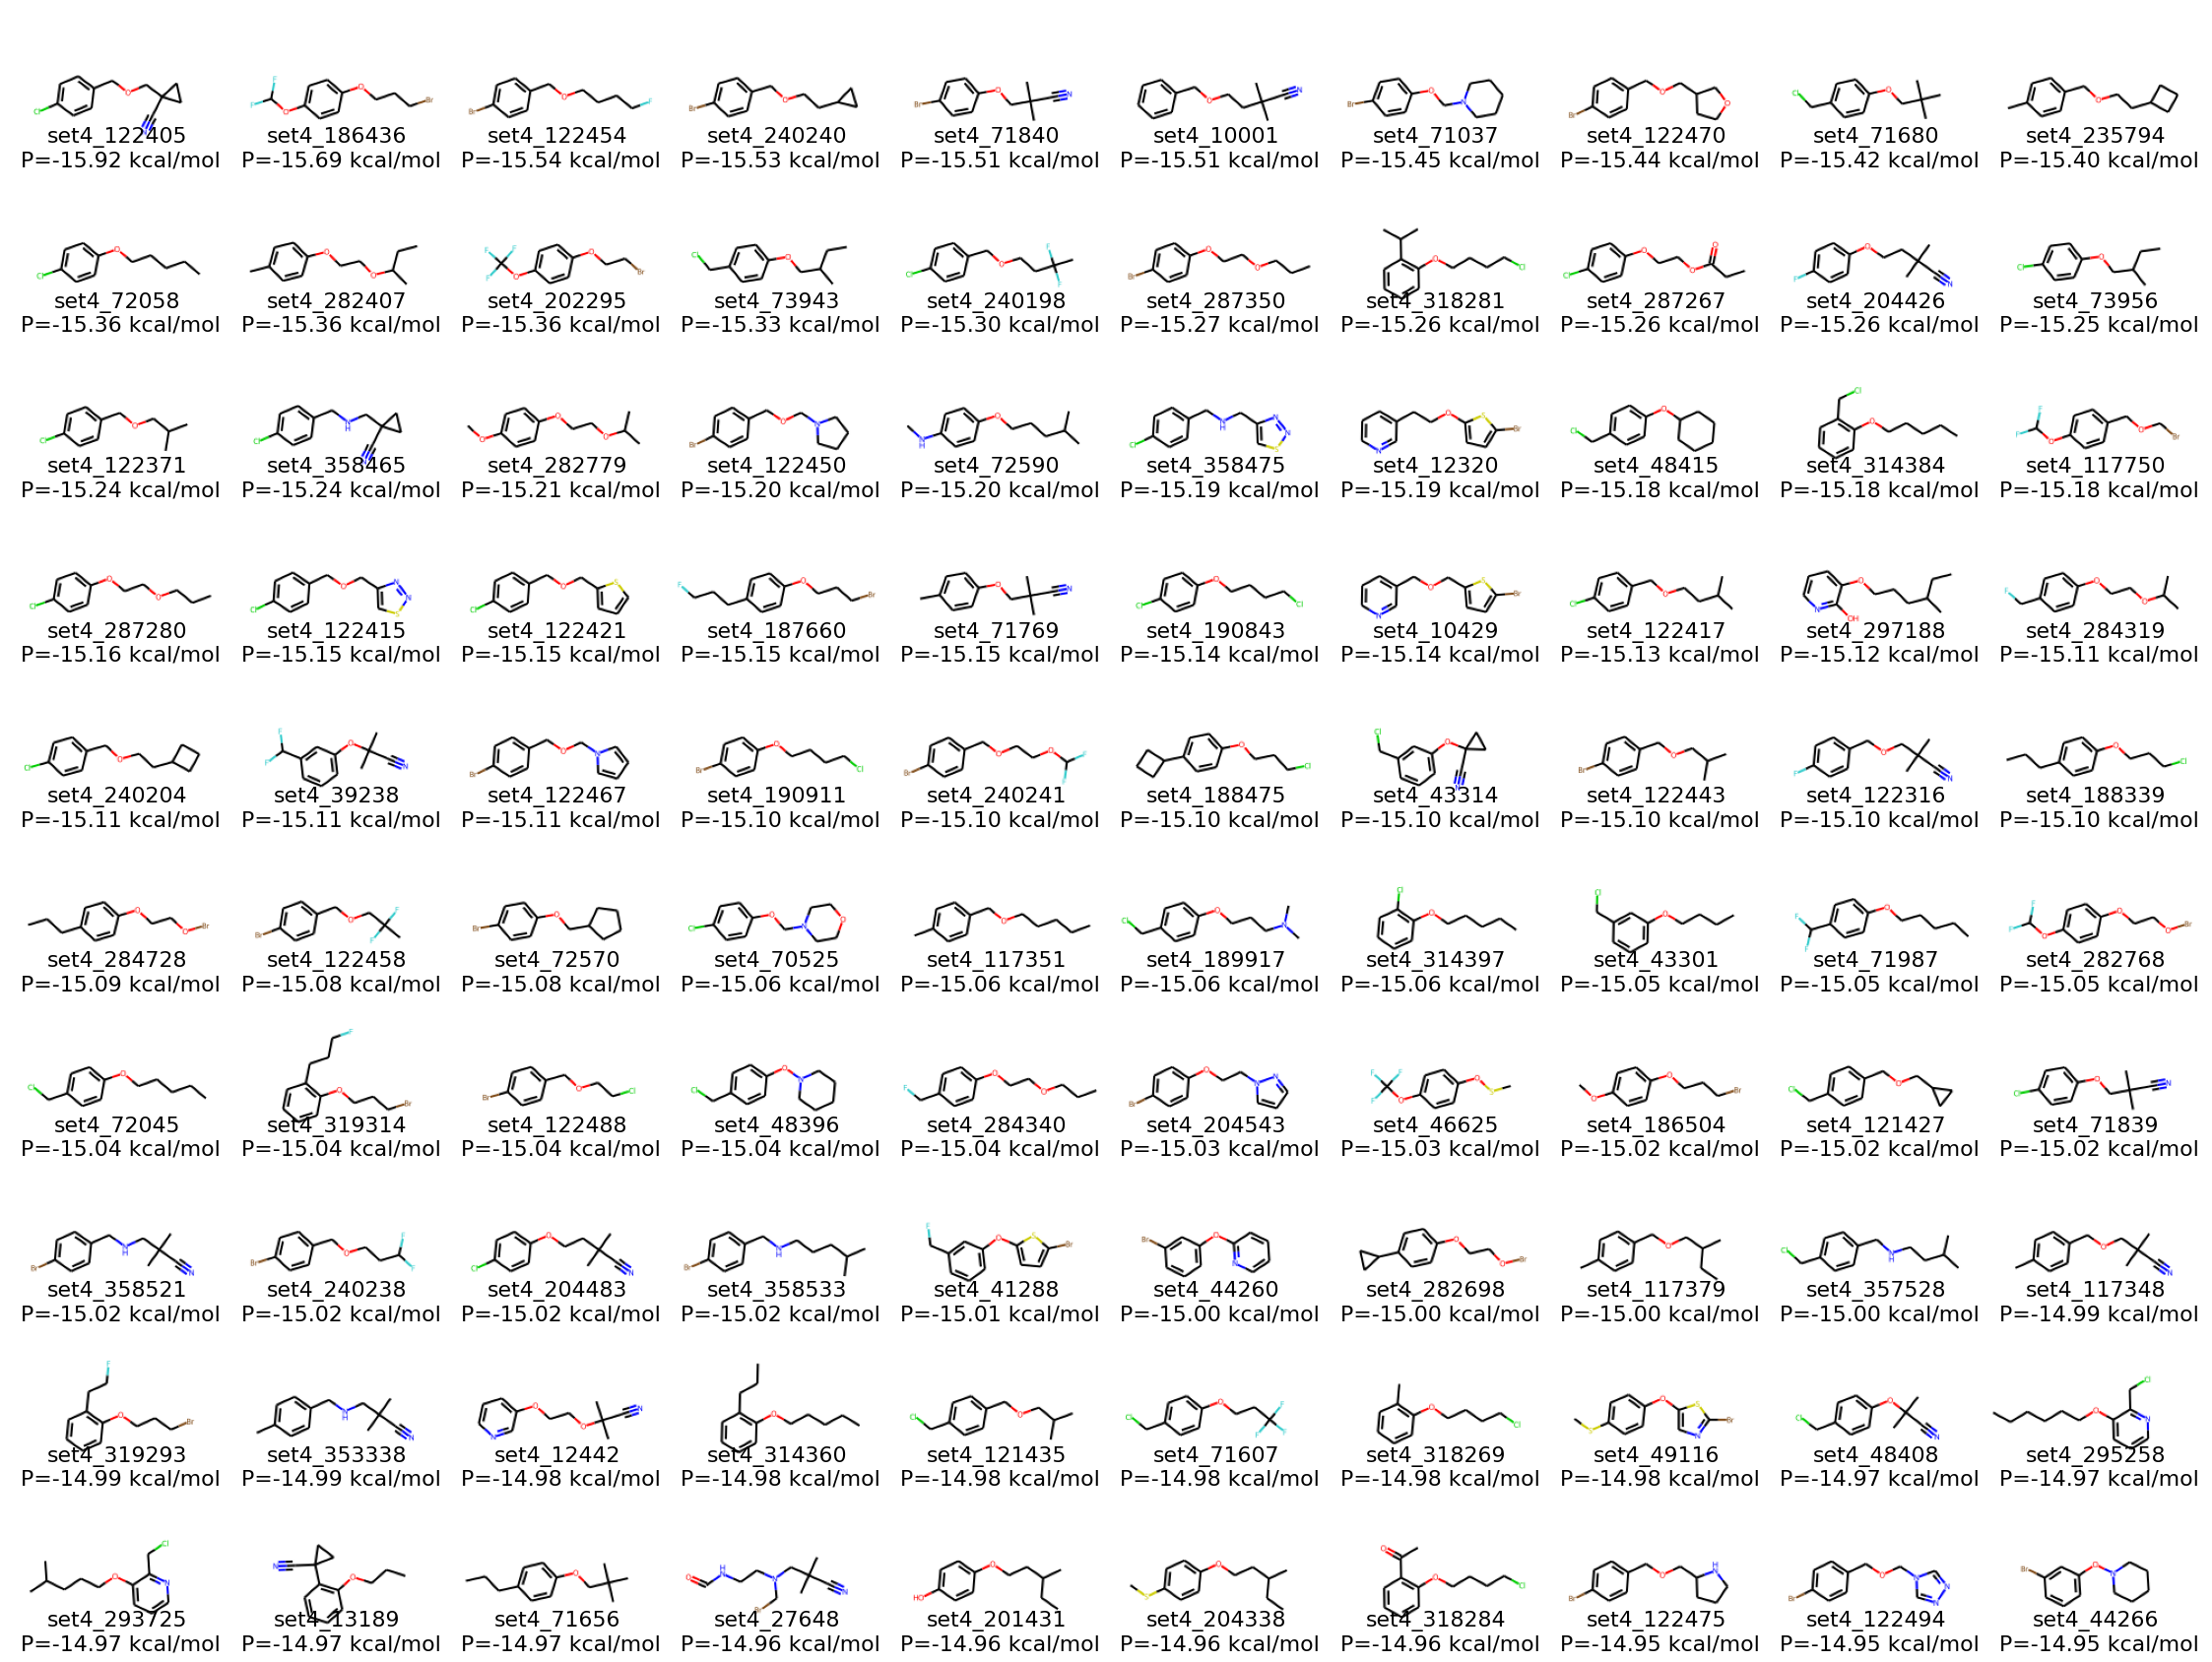

In [123]:
selected_ligs=[ligs_set4f[i] for i in new_lig_ids]
legends=[f"{ligs_set4f[i].GetProp('ID')}\n P={P[i]:.2f} kcal/mol" for i in new_lig_ids]

selected_RGroups=[Chem.MolFromSmiles(Chem.MolToSmiles(no_core_ligs_set4f[i])) for i in new_lig_ids]
grid_mols_with_annotation(selected_RGroups, legends,
                     sub_img_size =(200,150), mols_per_row=10, y_offset=-5)

In [ ]:
with open( pocket_fit_folder+"/step_6_picks.pickle", "wb" ) as f:
    pickle.dump(selected_ligs, f)